In [1]:
"""
Data (Daily & Minute): Binance API-Will need Binance API keys to be able to pull the data. 
Binance API Documentation: https://binance-docs.github.io/apidocs/spot/en/#introduction

"""

'\nData (Daily & Minute): Binance API-Will need Binance API keys to be able to pull the data. \nBinance API Documentation: https://binance-docs.github.io/apidocs/spot/en/#introduction\n\n'

In [2]:
# J.Guanzon Comment-Imports needed to run this file
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
import pandas as pd
import os
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [3]:
# Pull API keys from .env file
api_key = os.environ.get("api_key")
api_secret = os.environ.get("api_secret")

In [4]:
client = Client(api_key, api_secret)

In [5]:
# J.Guanzon Comment: Gather tickers for all
tickers = client.get_all_tickers()

In [6]:
ticker_df = pd.DataFrame(tickers)

In [7]:
ticker_df.set_index('symbol', inplace=True)
ticker_df

,price
symbol,
ETHBTC,0.06332500
LTCBTC,0.00307000
BNBBTC,0.00765400
NEOBTC,0.00073000
QTUMETH,0.00331000
...,...
LUNAAUD,49.68000000
TROYBUSD,0.01968800
AXSETH,0.03268000


In [8]:
""" 
Ability to save csv file of all tickers.
Allows the user to see what types of cryptocurrencies are out there.
For now, we will only focus on Bitcoin.
"""

' \nAbility to save csv file of all tickers.\nAllows the user to see what types of cryptocurrencies are out there.\nFor now, we will only focus on Bitcoin.\n'

In [9]:
ticker_df.to_csv("Resources/binance_tickers.csv")

In [10]:
display(float(ticker_df.loc['BTCUSDT']['price']))

60984.72

In [11]:
depth = client.get_order_book(symbol='BTCUSDT')

In [12]:
depth_df = pd.DataFrame(depth['asks'])
depth_df.columns = ['Price', 'Volume']
depth_df.head()

,Price,Volume
0,60984.72000000,0.26902000
1,60984.73000000,0.01000000
2,60984.74000000,0.01272000
3,60990.36000000,0.04100000
4,60990.69000000,0.06005000


In [13]:
"""
Pulling historical daily data
"""

'\nPulling historical daily data\n'

In [14]:
btc_daily_data = client.get_historical_klines('BTCUSDT', Client.KLINE_INTERVAL_1DAY, '1 Jan 2021')

In [15]:
btc_daily_df = pd.DataFrame(btc_daily_data)
btc_daily_df.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 
                    'Number of Trades', 'TB Base Volume', 'TB Quote Volume', 'Ignore']

In [16]:
btc_daily_df['Open Time'] = pd.to_datetime(btc_daily_df['Open Time']/1000, unit='s')
btc_daily_df['Close Time'] = pd.to_datetime(btc_daily_df['Close Time']/1000, unit='s')

In [17]:
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume']
btc_daily_df[numeric_columns] = btc_daily_df[numeric_columns].apply(pd.to_numeric, axis=1)

In [18]:
btc_ohlcv_daily = btc_daily_df.iloc[:,0:6]
btc_ohlcv_daily = btc_ohlcv_daily.set_index('Open Time')
btc_ohlcv_daily

,Open,High,Low,Close,Volume
Open Time,,,,,
2021-01-01,28923.63,29600.00,28624.57,29331.69,54182.925011
2021-01-02,29331.70,33300.00,28946.53,32178.33,129993.873362
2021-01-03,32176.45,34778.11,31962.99,33000.05,120957.566750
2021-01-04,33000.05,33600.00,28130.00,31988.71,140899.885690
2021-01-05,31989.75,34360.00,29900.00,33949.53,116049.997038
...,...,...,...,...,...
2021-10-12,57471.35,57680.00,53879.00,55996.93,53471.285500
2021-10-13,55996.91,57777.00,54167.19,57367.00,55808.444920
2021-10-14,57370.83,58532.54,56818.05,57347.94,43053.336781


In [19]:
btc_ohlcv_daily.to_csv("Resources/daily_btc_ohclv_2021.csv")

In [20]:
"""
Pulling historical minute data 
"""

'\nPulling historical minute data \n'

In [21]:
historical_minute = client.get_historical_klines('BTCUSDC', Client.KLINE_INTERVAL_1MINUTE, '5 day ago UTC')

In [22]:
hist_min = pd.DataFrame(historical_minute)

In [23]:
hist_min.columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 'Quote Asset Volume', 
                    'Number of Trades', 'TB Base Volume', 'TB Quote Volume', 'Ignore']

In [24]:
hist_min['Open Time'] = pd.to_datetime(hist_min['Open Time']/1000, unit='s')
hist_min['Close Time'] = pd.to_datetime(hist_min['Close Time']/1000, unit='s')


In [25]:
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume', 'TB Base Volume', 'TB Quote Volume']
hist_min[numeric_columns] = hist_min[numeric_columns].apply(pd.to_numeric, axis=1)

In [26]:
btc_ohlcv_minute = hist_min.iloc[:,0:6]
btc_ohlcv_minute = btc_ohlcv_minute.set_index('Open Time')
btc_ohlcv_minute

,Open,High,Low,Close,Volume
Open Time,,,,,
2021-10-11 19:28:00,57629.32,57630.37,57606.73,57613.52,1.90581
2021-10-11 19:29:00,57606.39,57606.39,57586.68,57586.68,0.55574
2021-10-11 19:30:00,57599.98,57636.97,57599.98,57629.90,0.48589
2021-10-11 19:31:00,57621.00,57636.97,57620.38,57632.04,0.72463
2021-10-11 19:32:00,57636.32,57638.49,57627.04,57631.57,0.16191
...,...,...,...,...,...
2021-10-16 19:24:00,61009.43,61031.93,61009.43,61024.38,0.28863
2021-10-16 19:25:00,61009.50,61015.76,60992.91,60992.91,0.08277
2021-10-16 19:26:00,60994.81,60997.30,60955.37,60968.90,1.03657


In [27]:
btc_ohlcv_minute.to_csv("Resources/minute_btc_ohclv_2021.csv")

In [28]:
"""
Next, we will be using the daily data for our Recurrent Neural Network. We are using Recurrent Neural Network for its use of time series and sequential data. 
RNN specializes in using information from prior inputs and uses it to influence current inputs and outputs, and the cycle repeats. 
"""

'\nNext, we will be using the daily data for our Recurrent Neural Network. We are using Recurrent Neural Network for its use of time series and sequential data. \nRNN specializes in using information from prior inputs and uses it to influence current inputs and outputs, and the cycle repeats. \n'

In [29]:
btc_df = pd.read_csv(Path("Resources/daily_btc_ohclv_2021.csv"), 
                     index_col= "Open Time")
target_col = 'Close'

In [30]:
# J.Guanzon Comment: Using an 80/20 split for our training data and testing data. Testing 2 other testing sizes to see if there are any differnces in accuracy.

def train_test_split(btc_df, test_size=0.2):
  split_row = len(btc_df) - int(test_size * len(btc_df))
  train_data = btc_df.iloc[:split_row]
  test_data = btc_df.iloc[split_row:]
  return train_data, test_data

train, test = train_test_split(btc_df, test_size=0.2)

# def train_test_split(btc_df, test_size=0.3):
#   split_row = len(btc_df) - int(test_size * len(btc_df))
#   train_data = btc_df.iloc[:split_row]
#   test_data = btc_df.iloc[split_row:]
#   return train_data, test_data

# train, test = train_test_split(btc_df, test_size=0.3)

# def train_test_split(btc_df, test_size=0.1):
#   split_row = len(btc_df) - int(test_size * len(btc_df))
#   train_data = btc_df.iloc[:split_row]
#   test_data = btc_df.iloc[split_row:]
#   return train_data, test_data

# train, test = train_test_split(btc_df, test_size=0.1)

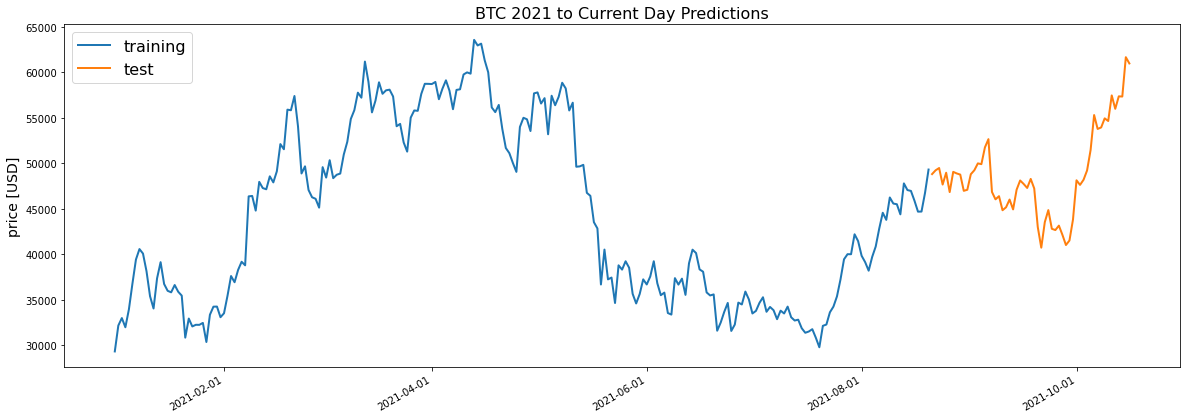

In [31]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(20, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    fmt_bimonthly = mdates.MonthLocator(interval=2)
    ax.xaxis.set_major_locator(fmt_bimonthly)
    ax.set_title(title, fontsize=16)
    fig.autofmt_xdate() 
    ax.legend(loc='best', fontsize=16)

line_plot(train[target_col], test[target_col], 'training', 'test', title='BTC 2021 to Current Day Predictions')

In [32]:
"""
Next, we have to prep the data for RNN by normalizing the numeric columns in the dataset to a common scale, without distorting differences in the range of values.
"""

'\nNext, we have to prep the data for RNN by normalizing the numeric columns in the dataset to a common scale, without distorting differences in the range of values.\n'

In [33]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [34]:
def extract_window_data(btc_df, window_len=10, zero_base=True):
    window_data = []
    for idx in range(len(btc_df) - window_len):
        tmp = btc_df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [35]:
# J.Guanzon Comment: We want to use the data from Jan-Jun 2021 and use the rest of the data to train and predict the rest of the data.
X_train= btc_df[:"2021-06-01"]
X_test = btc_df["2021-06-01":]
y_train = btc_df.loc[:"2021-06-01",target_col]
y_test = btc_df.loc["2021-06-01":,target_col]

In [36]:
def prepare_data(btc_df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(btc_df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

# def prepare_data(btc_df, target_col, window_len=10, zero_base=True, test_size=0.3):
#     train_data, test_data = train_test_split(btc_df, test_size=test_size)
#     X_train = extract_window_data(train_data, window_len, zero_base)
#     X_test = extract_window_data(test_data, window_len, zero_base)
#     y_train = train_data[target_col][window_len:].values
#     y_test = test_data[target_col][window_len:].values
#     if zero_base:
#         y_train = y_train / train_data[target_col][:-window_len].values - 1
#         y_test = y_test / test_data[target_col][:-window_len].values - 1

#     return train_data, test_data, X_train, X_test, y_train, y_test

# def prepare_data(btc_df, target_col, window_len=10, zero_base=True, test_size=0.1):
#     train_data, test_data = train_test_split(btc_df, test_size=test_size)
#     X_train = extract_window_data(train_data, window_len, zero_base)
#     X_test = extract_window_data(test_data, window_len, zero_base)
#     y_train = train_data[target_col][window_len:].values
#     y_test = test_data[target_col][window_len:].values
#     if zero_base:
#         y_train = y_train / train_data[target_col][:-window_len].values - 1
#         y_test = y_test / test_data[target_col][:-window_len].values - 1

#     return train_data, test_data, X_train, X_test, y_train, y_test

In [37]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    stm= LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2]))
    model.add(stm)
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [38]:
np.random.seed(50)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [39]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    btc_df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/100
8/8 [==============================] - 1s 3ms/step - loss: 0.0095
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0070
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0040
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 11/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 12/100
8/8 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 13/100
8/8 [==============================] - 0s 3ms/st

In [40]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.030368551568401077

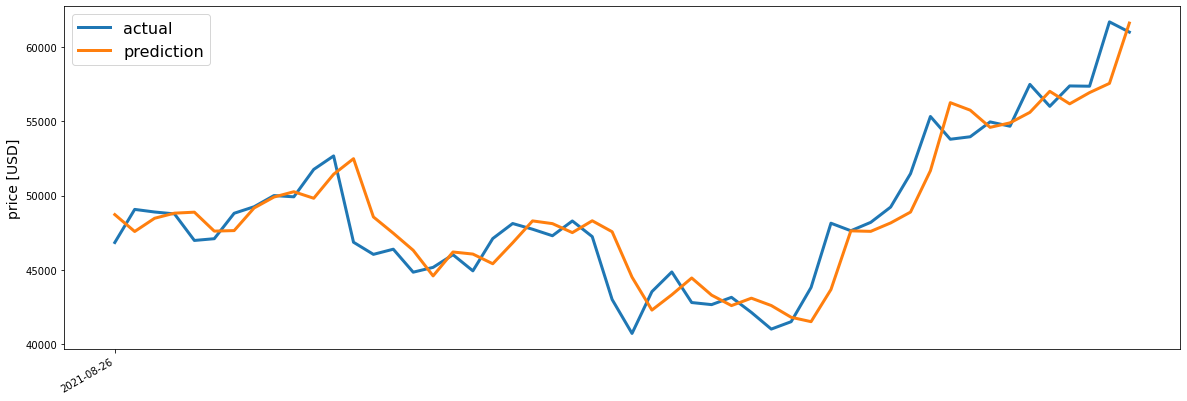

In [41]:
# Plotting predictions against the actual. 
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)